In [51]:
#필요한 모드 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np
import tensorflow as tf
from PIL import Image

from pathlib import Path
from keras import regularizers
from keras.applications import ResNet50
from IPython.display import Markdown, display
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [52]:
dir_ = Path('C:/Users/sbrrd/Desktop/153.반려동물 안구질환 데이터/01.데이터/1.Training/원천데이터/TL1/개/안구/일반')
test_dir_ = Path('C:/Users/sbrrd/Desktop/153.반려동물 안구질환 데이터/01.데이터/2.Validation/원천데이터/VS/개/안구/일반/')

import glob
types = ('**/*.jpg', '**/*.png','**/*.jpeg') # the tuple of file types
files_grabbed = []
test_files_grabbed = []
for files in types:
    files_grabbed.extend(dir_.glob(files))
    test_files_grabbed.extend(test_dir_.glob(files))

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = []
    for i in range(len(filepath)):
        if(str(filepath[i]).split("\\")[-2] == '무'):
            labels.append(str(filepath[i]).split("\\")[-2])
        else:
            labels.append(str(filepath[i]).split("\\")[-3])

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(files_grabbed)
test_df = proc_img(test_files_grabbed)
df.head(5)

,Filepath,Label
0,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
1,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
2,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
3,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
4,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,유루증


In [53]:
test_df.head(5)

,Filepath,Label
0,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,비궤양성각막질환
1,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
2,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,궤양성각막질환
3,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
4,C:\Users\sbrrd\Desktop\153.반려동물 안구질환 데이터\01.데이...,무


In [54]:
#데이터 라벨링된 결과
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}\n')

#데이터 라벨링된 결과
print(f'Number of pictures: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(test_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')

Number of pictures: 176310

Number of different labels: 11

Labels: ['무' '백내장' '유루증' '비궤양성각막질환' '안검염' '결막염' '핵경화' '안검종양' '궤양성각막질환' '안검내반증'
 '색소침착성각막염']

Number of pictures: 22058

Number of different labels: 11

Labels: ['비궤양성각막질환' '무' '궤양성각막질환' '백내장' '색소침착성각막염' '유루증' '결막염' '핵경화' '안검내반증'
 '안검종양' '안검염']


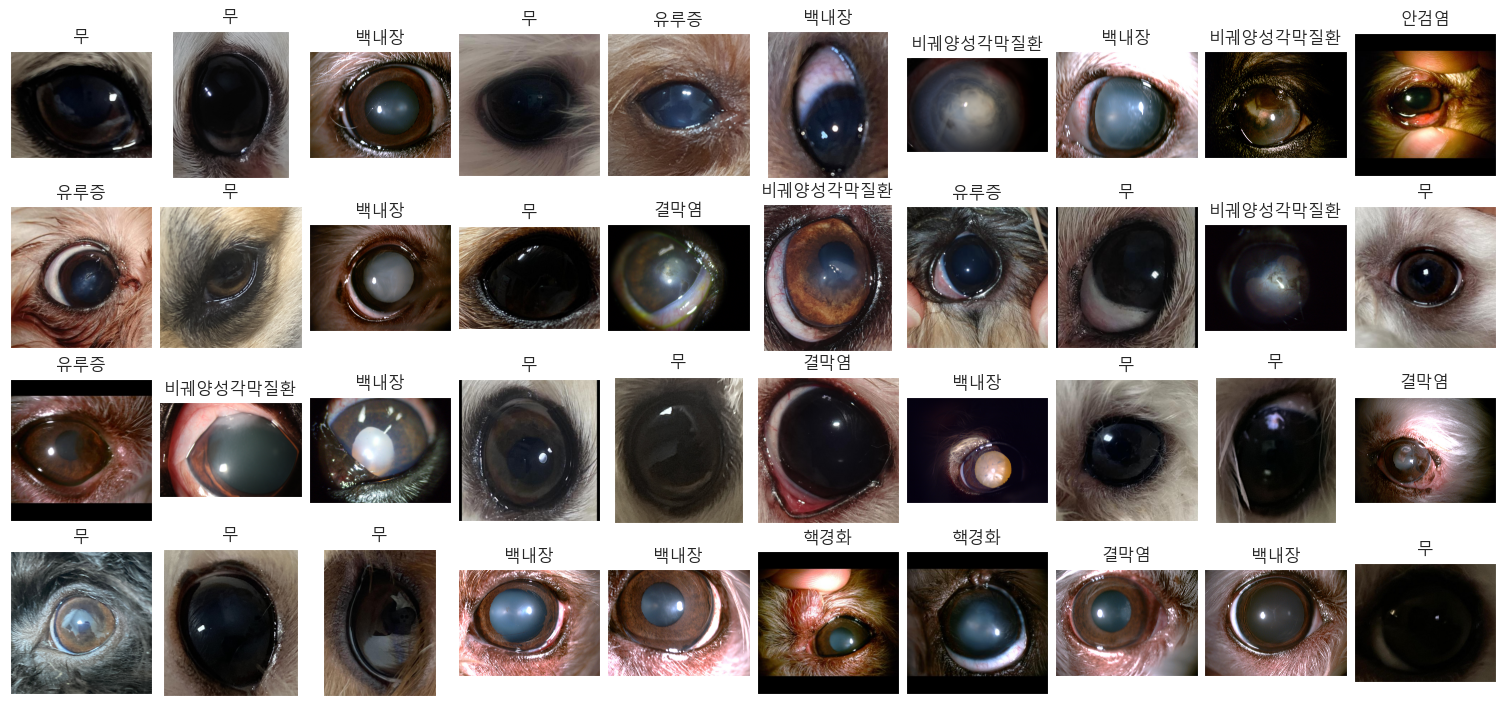

In [55]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

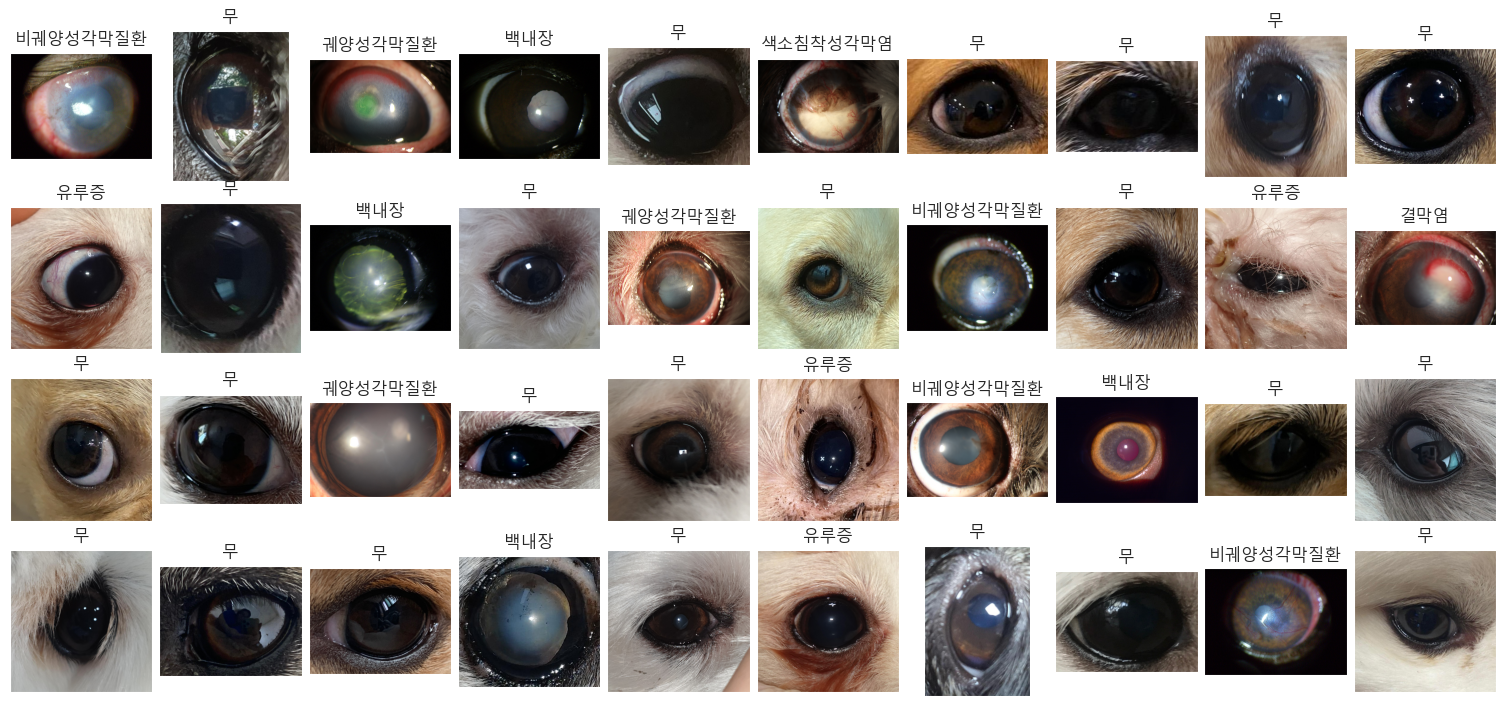

In [56]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(test_df.Filepath[i]))
    ax.set_title(test_df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

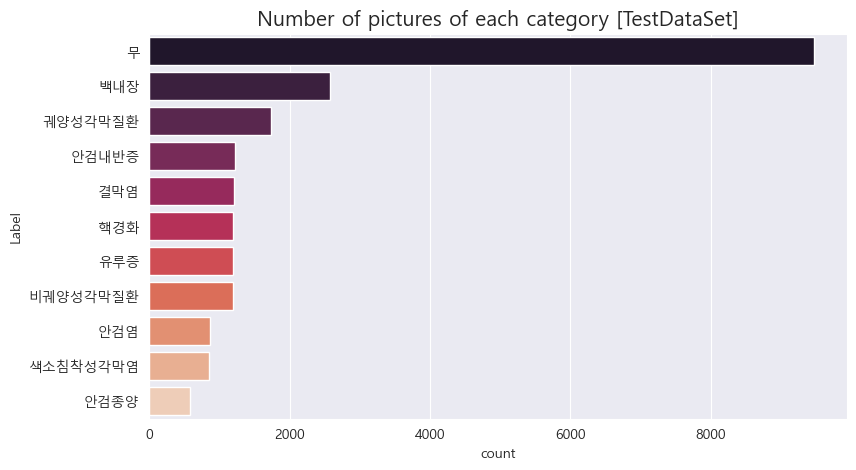

In [57]:
vc = test_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category [TestDataSet]", fontsize = 15)
plt.show()

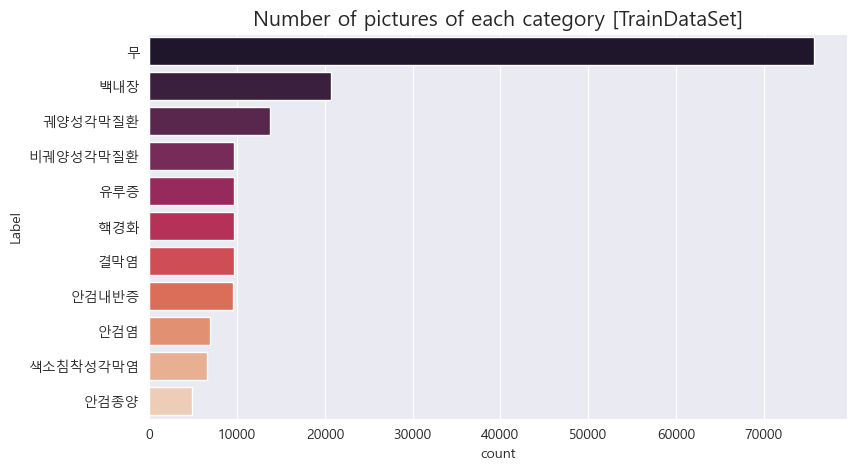

In [58]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category [TrainDataSet]", fontsize = 15)
plt.show()

In [59]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

# def get_model(model):
# # Load the pretained model
#     kwargs =    {'input_shape':(224, 224, 3),
#                 'include_top':False,
#                 'weights':'imagenet',
#                 'pooling':'avg'}
#
#     pretrained_model = model(**kwargs)
#     pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
#
#     x = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(pretrained_model.output)
#     x = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
#
#     outputs = tf.keras.layers.Dense(11, activation='softmax')(x)
#     # 라벨 개수가 11개이기 때문에 Dencs도 11로 설정
#     model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)
#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
#
#     return model

# tf.keras.applications.DenseNet201

def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(11, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [60]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_v2.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]


train_generator,test_generator,train_images,val_images,test_images=create_gen()

with tf.device('/GPU:0'):
    model = get_model() #가장 좋은 성과를 낸 모델을 사용
    history = model.fit(train_images,validation_data=val_images,epochs=7 ,callbacks=callbacks)

Found 141048 validated image filenames belonging to 11 classes.
Found 35262 validated image filenames belonging to 11 classes.
Found 22058 validated image filenames belonging to 11 classes.
Epoch 1/7
4408/4408 [==============================] - 7313s 2s/step - loss: 1.0487 - accuracy: 0.6116 - val_loss: 0.8939 - val_accuracy: 0.6613
Epoch 2/7
4408/4408 [==============================] - 7190s 2s/step - loss: 0.8653 - accuracy: 0.6636 - val_loss: 0.8382 - val_accuracy: 0.6673
Epoch 3/7
4408/4408 [==============================] - 7339s 2s/step - loss: 0.7835 - accuracy: 0.6932 - val_loss: 0.9050 - val_accuracy: 0.6683
Epoch 4/7
4408/4408 [==============================] - 7242s 2s/step - loss: 0.7229 - accuracy: 0.7153 - val_loss: 0.7775 - val_accuracy: 0.7011
Epoch 5/7
4408/4408 [==============================] - 7289s 2s/step - loss: 0.6703 - accuracy: 0.7347 - val_loss: 0.8133 - val_accuracy: 0.6961
Epoch 6/7
4408/4408 [==============================] - 7343s 2s/step - loss: 0.6237 -

In [61]:
model.save('best_model_v2.h5')

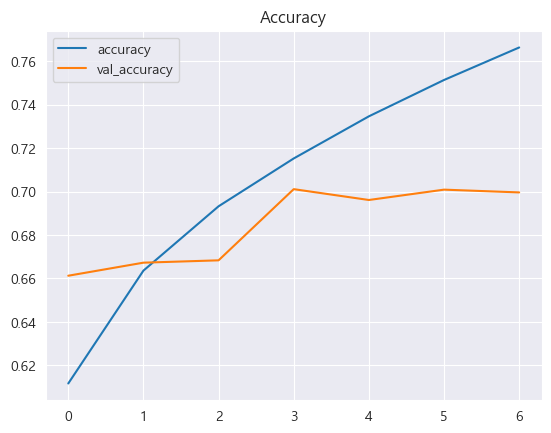

In [62]:
#정확도
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

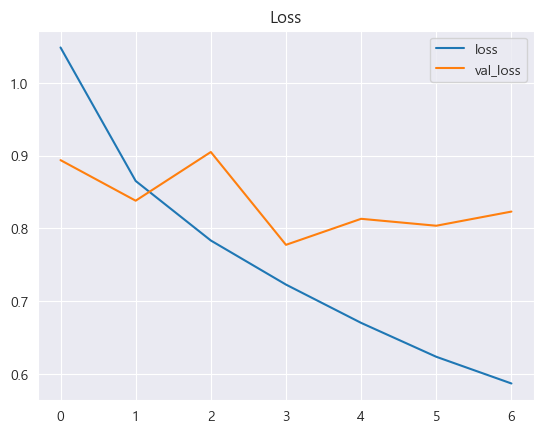

In [63]:
#손실도
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()